In [1]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')


--2023-07-23 04:26:42--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   104MB/s    in 0.8s    

2023-07-23 04:26:43 (104 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('bioactivity_preprocessed_data.csv')

In [4]:
!pip install rdkit

     |████████████████████████████████| 29.5 MB 1.4 MB/s 


In [5]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [6]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [7]:
df_lipinski = lipinski(df.canonical_smiles)
df_combined = pd.concat([df, df_lipinski], axis = 1 )
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,Class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL184136,COc1ccc(CSc2nc(O)cc(C(F)(F)F)n2)cc1,17000.0,inactive,316.304,3.50190,1.0,5.0
1,CHEMBL182801,COc1ccc(CNc2nc(O)cc(C(F)(F)F)n2)cc1,100000.0,inactive,299.252,2.82170,2.0,5.0
2,CHEMBL184852,Oc1cc(C(F)(F)F)nc(NCc2ccc(Cl)cc2)n1,100000.0,inactive,303.671,3.46650,2.0,4.0
3,CHEMBL184142,CN(Cc1ccc(Cl)cc1)c1nc(O)cc(C(F)(F)F)n1,100000.0,inactive,317.698,3.49080,1.0,4.0
4,CHEMBL185326,CN(Cc1ccccc1)c1nc(O)cc(C(F)(F)F)n1,100000.0,inactive,283.253,2.83740,1.0,4.0
...,...,...,...,...,...,...,...,...
68,CHEMBL4851660,O=C(O)c1cc(NS(=O)(=O)c2ccc(-c3ccc(F)cc3Cl)c3cc...,103700.0,inactive,473.884,5.93740,2.0,3.0
69,CHEMBL4868426,O=C(O)c1cc(NS(=O)(=O)c2ccc(-c3ccc(F)c(Cl)c3)c3...,103050.0,inactive,473.884,5.93740,2.0,3.0
70,CHEMBL4866912,Cc1c(Cl)cccc1OCc1[nH]c2nc(-c3ccccc3)nn2c(=O)c1C,1950.0,intermediate,380.835,3.93384,1.0,5.0
71,CHEMBL4280900,CCc1c(-c2ccccc2)c(-c2ccccc2)nn1-c1ccccc1-c1ccc...,35780.0,inactive,474.560,6.89910,1.0,4.0


# Normalize the Data - Prep

In [8]:
def pIC50_converting(input):
  pIC50 = []

  for i in input['standard_value_norm']:
    molar = i*(10**-9)
    pIC50.append(-np.log10(molar))

  input['pIC50'] = pIC50
  x = input.drop('standard_value_norm', 1)

  return x

In [9]:
df_combined.standard_value.describe()

count    7.300000e+01
mean     7.924761e+05
std      2.574502e+06
min      3.400000e+01
25%      1.950000e+03
50%      1.000000e+04
75%      1.000000e+05
max      1.000000e+07
Name: standard_value, dtype: float64

In [10]:
-np.log10((10**-9)*100000000)

1.0

In [11]:
-np.log10((10**-9)*10000000000)

-1.0

In [12]:
def standardize_normal_value(input):
  norm = []
  for i in input['standard_value']:
    if i > 100000000:
      i = 100000000
    norm.append(i)

  input['standard_value_norm'] = norm
  x = input.drop('standard_value', 1)

  return x

In [13]:
df_norm = standardize_normal_value(df_combined)
df_norm

<ipython-input-12-fdee2eb4c0b6>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = input.drop('standard_value', 1)


,molecule_chembl_id,canonical_smiles,Class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL184136,COc1ccc(CSc2nc(O)cc(C(F)(F)F)n2)cc1,inactive,316.304,3.50190,1.0,5.0,17000.0
1,CHEMBL182801,COc1ccc(CNc2nc(O)cc(C(F)(F)F)n2)cc1,inactive,299.252,2.82170,2.0,5.0,100000.0
2,CHEMBL184852,Oc1cc(C(F)(F)F)nc(NCc2ccc(Cl)cc2)n1,inactive,303.671,3.46650,2.0,4.0,100000.0
3,CHEMBL184142,CN(Cc1ccc(Cl)cc1)c1nc(O)cc(C(F)(F)F)n1,inactive,317.698,3.49080,1.0,4.0,100000.0
4,CHEMBL185326,CN(Cc1ccccc1)c1nc(O)cc(C(F)(F)F)n1,inactive,283.253,2.83740,1.0,4.0,100000.0
...,...,...,...,...,...,...,...,...
68,CHEMBL4851660,O=C(O)c1cc(NS(=O)(=O)c2ccc(-c3ccc(F)cc3Cl)c3cc...,inactive,473.884,5.93740,2.0,3.0,103700.0
69,CHEMBL4868426,O=C(O)c1cc(NS(=O)(=O)c2ccc(-c3ccc(F)c(Cl)c3)c3...,inactive,473.884,5.93740,2.0,3.0,103050.0
70,CHEMBL4866912,Cc1c(Cl)cccc1OCc1[nH]c2nc(-c3ccccc3)nn2c(=O)c1C,intermediate,380.835,3.93384,1.0,5.0,1950.0
71,CHEMBL4280900,CCc1c(-c2ccccc2)c(-c2ccccc2)nn1-c1ccccc1-c1ccc...,inactive,474.560,6.89910,1.0,4.0,35780.0


In [14]:
df_normalized = pIC50_converting(df_norm)
df_normalized

<ipython-input-8-0464f7f5b1a8>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = input.drop('standard_value_norm', 1)


,molecule_chembl_id,canonical_smiles,Class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL184136,COc1ccc(CSc2nc(O)cc(C(F)(F)F)n2)cc1,inactive,316.304,3.50190,1.0,5.0,4.769551
1,CHEMBL182801,COc1ccc(CNc2nc(O)cc(C(F)(F)F)n2)cc1,inactive,299.252,2.82170,2.0,5.0,4.000000
2,CHEMBL184852,Oc1cc(C(F)(F)F)nc(NCc2ccc(Cl)cc2)n1,inactive,303.671,3.46650,2.0,4.0,4.000000
3,CHEMBL184142,CN(Cc1ccc(Cl)cc1)c1nc(O)cc(C(F)(F)F)n1,inactive,317.698,3.49080,1.0,4.0,4.000000
4,CHEMBL185326,CN(Cc1ccccc1)c1nc(O)cc(C(F)(F)F)n1,inactive,283.253,2.83740,1.0,4.0,4.000000
...,...,...,...,...,...,...,...,...
68,CHEMBL4851660,O=C(O)c1cc(NS(=O)(=O)c2ccc(-c3ccc(F)cc3Cl)c3cc...,inactive,473.884,5.93740,2.0,3.0,3.984221
69,CHEMBL4868426,O=C(O)c1cc(NS(=O)(=O)c2ccc(-c3ccc(F)c(Cl)c3)c3...,inactive,473.884,5.93740,2.0,3.0,3.986952
70,CHEMBL4866912,Cc1c(Cl)cccc1OCc1[nH]c2nc(-c3ccccc3)nn2c(=O)c1C,intermediate,380.835,3.93384,1.0,5.0,5.709965
71,CHEMBL4280900,CCc1c(-c2ccccc2)c(-c2ccccc2)nn1-c1ccccc1-c1ccc...,inactive,474.560,6.89910,1.0,4.0,4.446360


In [15]:
df_final = df_normalized[df_normalized.Class != 'intermediate']
df_final

,molecule_chembl_id,canonical_smiles,Class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL184136,COc1ccc(CSc2nc(O)cc(C(F)(F)F)n2)cc1,inactive,316.304,3.50190,1.0,5.0,4.769551
1,CHEMBL182801,COc1ccc(CNc2nc(O)cc(C(F)(F)F)n2)cc1,inactive,299.252,2.82170,2.0,5.0,4.000000
2,CHEMBL184852,Oc1cc(C(F)(F)F)nc(NCc2ccc(Cl)cc2)n1,inactive,303.671,3.46650,2.0,4.0,4.000000
3,CHEMBL184142,CN(Cc1ccc(Cl)cc1)c1nc(O)cc(C(F)(F)F)n1,inactive,317.698,3.49080,1.0,4.0,4.000000
4,CHEMBL185326,CN(Cc1ccccc1)c1nc(O)cc(C(F)(F)F)n1,inactive,283.253,2.83740,1.0,4.0,4.000000
7,CHEMBL185595,O=C(O)CCCn1c2ccccc2c2ccccc21,active,253.301,3.65930,1.0,2.0,6.221849
9,CHEMBL364141,O=C(O)c1ccccc1S(=O)(=O)n1c2ccccc2c2ccccc21,inactive,351.383,3.72970,1.0,4.0,4.376751
11,CHEMBL474743,O=C(O)c1cccc2c3c(n(Cc4ccccc4F)c12)CCCC3,active,323.367,4.40570,1.0,2.0,6.167491
14,CHEMBL460750,O=C(O)c1cccc2c3c(n(Cc4ccccc4C(F)(F)F)c12)CCCCC3,active,387.401,5.67550,1.0,2.0,6.397940
15,CHEMBL514666,COc1cccc(Cn2c3c(c4cccc(C(=O)O)c42)CCCC3)c1,inactive,335.403,4.27520,1.0,3.0,5.000000


In [31]:
df_final.to_csv('data_final.csv', index=False)

# Exploratory data analysis

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid')

Text(0, 0.5, 'Frequency')

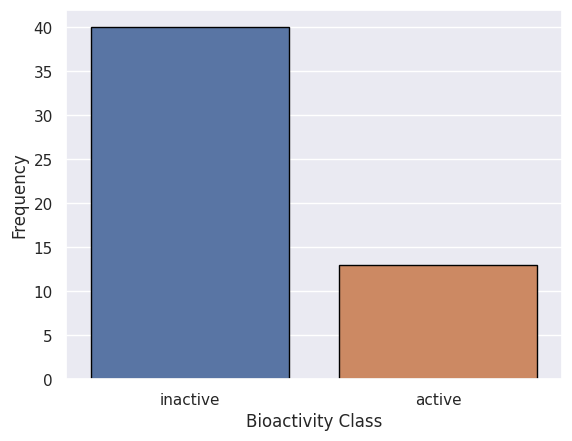

In [17]:
#compare the two bioactivity classes

sns.countplot(x='Class', data=df_final, edgecolor='black')
plt.xlabel('Bioactivity Class')
plt.ylabel('Frequency')

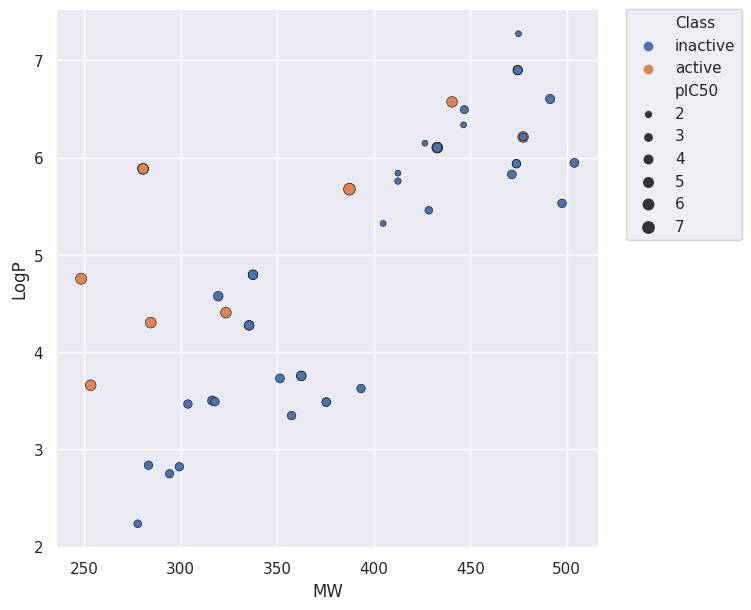

In [18]:
#visualize molecular weight with Logp
#color associated with Class
#size associated with pIC50

plt.figure(figsize=(7,7))

sns.scatterplot(x='MW', y = 'LogP', data= df_final, hue = 'Class', size = 'pIC50', edgecolor = 'black')
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0)

<Axes: xlabel='Class', ylabel='pIC50'>

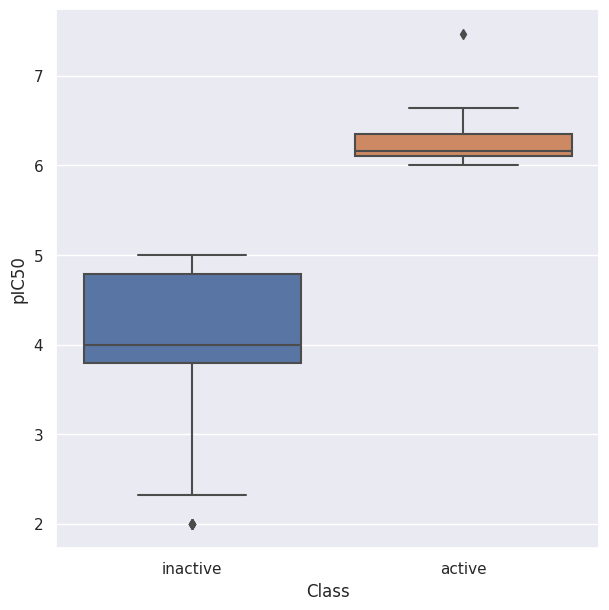

In [19]:
plt.figure(figsize=(7,7))

sns.boxplot(x='Class', y = 'pIC50', data = df_final)

# End of Visualization - Statistical analysis

In [20]:
#Mann-Whitney test

def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'Class']
  df = df_final[selection]
  active = df[df['Class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'Class']
  df = df_final[selection]
  inactive = df[df['Class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [21]:
mannwhitney('pIC50')    #null is rejected

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,520.0,7.067811e-08,0.05,Different distribution (reject H0)


# Analysis for each section:


*   MW
*   LogP
*   NumHDonors
*   NumHAcceptors








<Axes: xlabel='Class', ylabel='MW'>

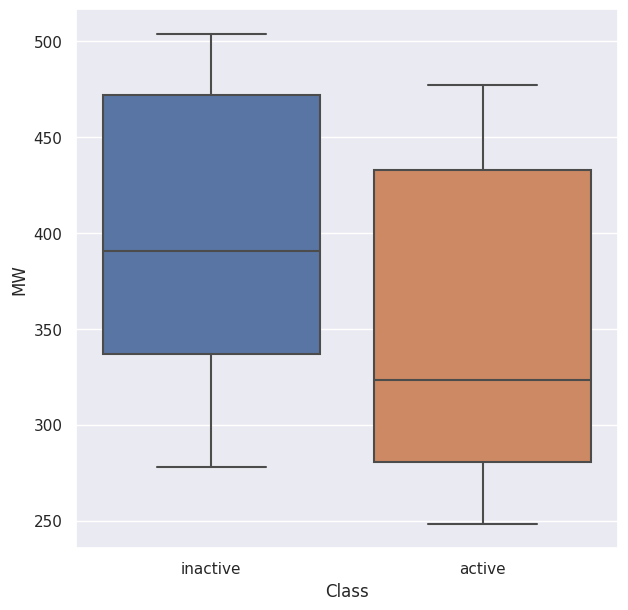

In [22]:
plt.figure(figsize=(7,7))
sns.boxplot(x='Class', y = 'MW', data = df_final)

In [23]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,167.5,0.057048,0.05,Same distribution (fail to reject H0)


<Axes: xlabel='Class', ylabel='LogP'>

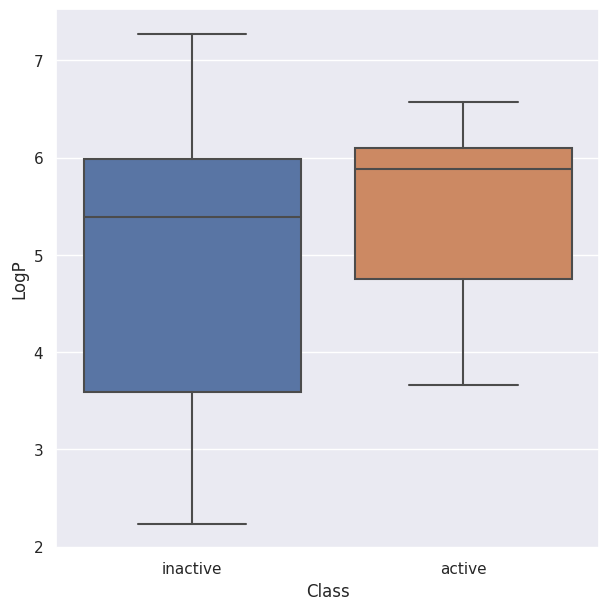

In [24]:
plt.figure(figsize=(7,7))
sns.boxplot(x='Class', y = 'LogP', data = df_final)

In [25]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,312.0,0.286897,0.05,Same distribution (fail to reject H0)


<Axes: xlabel='Class', ylabel='NumHDonors'>

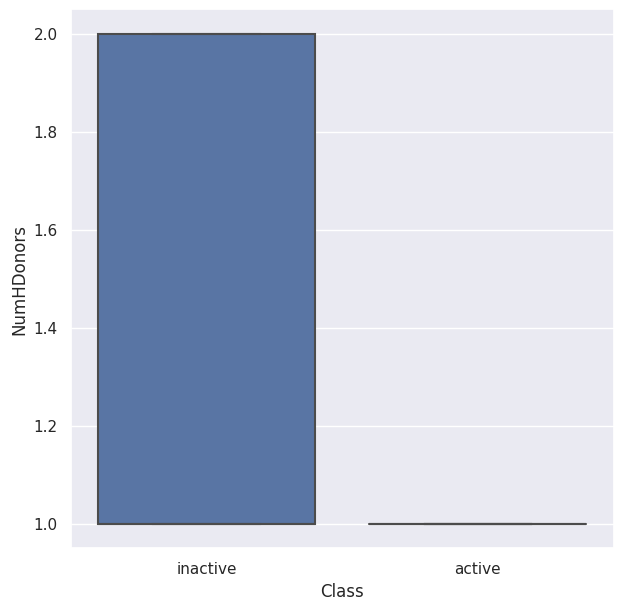

In [26]:
plt.figure(figsize=(7,7))
sns.boxplot(x='Class', y = 'NumHDonors', data = df_final)

In [27]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,162.5,0.010182,0.05,Different distribution (reject H0)


<Axes: xlabel='Class', ylabel='NumHAcceptors'>

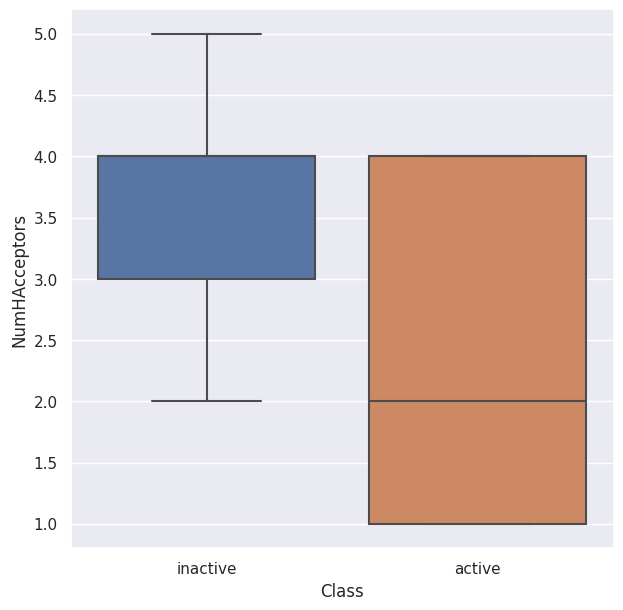

In [28]:
plt.figure(figsize=(7,7))
sns.boxplot(x='Class', y = 'NumHAcceptors', data = df_final)

In [29]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,112.5,0.000928,0.05,Different distribution (reject H0)


Only NumHAcceptors/Donors showed statistically significance differences between active / inactive pIC50 values